Ở phần này, tôi sử dụng bộ dữ liệu sparkify và spark dể xử lý sau đó thử nghiệm trên cloud với bộ dữ liệu 12GB


In [1]:
!pip install pyspark


     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 198 kB 54.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=38e33f0582216a319c31a5fbd2d220ac5540c9aebb22e58fd265228973dc838a
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession, Window
from pyspark import SparkFiles
from pyspark.sql.functions import avg, col, concat, count, desc, \
asc, explode, lit, split, stddev, udf, isnan, when, rank, array, \
log, sqrt, cbrt, exp, countDistinct, monotonically_increasing_id, collect_list, dayofweek
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import abs as Fabs

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from time import time
import re
import numpy as np
import datetime
import random
random.seed(42)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Get dataset

In [5]:
event_data = "/content/drive/MyDrive/Đại học/Data/Churn/Sparkify/mini_sparkify_event_data.json"
df_original = spark.read.json(event_data)

In [6]:
df=df_original

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)





```
Trường user_id có giá rỗng ở các page không cần đăng nhập cũng có thể sử dụng.
```



In [ ]:
df.filter(df['userId']=='').groupBy('page').count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
|              Error|    6|
+-------------------+-----+





```
Đếm số page xuất hiện trong tập dữ liệu
```



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

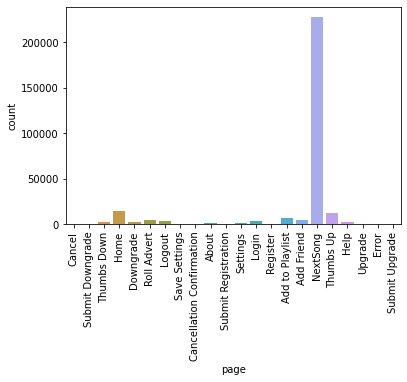

In [8]:
page_pd = df.groupBy('page').count().toPandas()
sns.barplot(x='page', y='count', data=page_pd)
plt.xticks(rotation = 90)



```
Drop các bản ghi user_id và session_id rỗng
Tuy nhiên session_id không có giá trị rỗng, có thể là chưa xuất hiện ở tập dữ liệu nhỏ này.
```



In [8]:
df = df.dropna(how='any', subset=['userId','sessionId'])
df = df.filter(df['userId']!='')



```
Định nghĩa Churn
```



In [9]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df.withColumn("churned", flag_churn_event("page").cast(IntegerType()))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(Fmax('churned').alias("churn"))

user_cancel_time = df.filter(df['page']=='Cancellation Confirmation')\
                      .select(['userId','ts'])
                      

churn = churn.join(user_cancel_time,['userId'], how='left')\
            .fillna(0)\
            .withColumn('cancel_day',col('ts'))\
            .select(['userId','churn','cancel_day'])



```
Chuyển timestamp về dạng datetime
Lấy các thứ trong tuần từ date_time
```



In [11]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df=df.withColumn('event_date_time',get_date('ts'))
df=df.withColumn('registration_date_time', get_date('registration'))

In [12]:
df = df.withColumn('event_day_of_week', ((dayofweek('event_date_time')+5)%7)+1)
# df.select('event_day_of_week').dropDuplicates().show()



```
Tạo cột gender
1 là Male
0 là Female
```



In [14]:
get_gender= udf(lambda x: 1 if x=='M' else 0)
user_gender = df.select(['userId','gender']).dropDuplicates()
user_gender = user_gender.withColumn('gender', get_gender('gender'))



```
Tạo cột level
```



In [16]:
get_level = udf(lambda x: 1 if x=='paid' else 0)
user_level = df.select(['userId', 'level','ts'])\
                .orderBy(desc('ts'))\
                .select(['userId','level'])\
                .dropDuplicates(['userId'])\
                .withColumn('level', get_level('level').cast(IntegerType()))



```
Tống số bài nhạc đã nghe
Số ngày kể từ lần cuối tương tác
Tổng số Thumb up,down (sô đánh giá)
Tổng số lần xem ads
Thời gian từ lúc đăng kí
```



In [17]:
user_sum_song = df.filter(~df['song'].isNull())\
                  .dropDuplicates(['userId','song'])\
                  .groupBy('userId')\
                  .agg(count('song').cast(IntegerType()).alias('sum_song_listened'))\

In [29]:

last_time_check = df.agg({'ts':'max'}).collect()[0][0]
get_last_interaction = udf(lambda x: (last_time_check-x)/(24*60*60*1000))
user_last_reaction = df.groupBy('userId')\
                      .agg(Fmax('ts').alias('last_interaction'))\
                      .withColumn('days_from_last_interaction',get_last_interaction('last_interaction').cast(FloatType()))


time_since_regi = df.select(['userId','registration'])\
                    .withColumn('time_since_regis',get_last_interaction('registration').cast(FloatType()))\

In [30]:
user_thumb_up = df.filter(df['page'].isin(['Thumbs Up']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Thumb_up_times'))\

user_thumb_down = df.filter(df['page'].isin(['Thumbs Down']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Thumb_down_times'))

user_ads = df.filter(df['page'].isin(['Roll Advert']))\
                .groupBy(['userId'])\
                .agg(count('page').cast(IntegerType()).alias('Num_ads'))

In [31]:
week_day_login = df.filter(df['event_day_of_week'] < 6)\
                    .select(['userId','sessionId'])\
                    .dropDuplicates()\
                    .groupBy(['userId'])\
                    .agg(count('sessionId').cast(IntegerType()).alias('week_day_logins'))

weekeend_login = df.filter(df['event_day_of_week'] > 5)\
                    .select(['userId','sessionId'])\
                    .dropDuplicates()\
                    .groupBy(['userId'])\
                    .agg(count('sessionId').cast(IntegerType()).alias('weekeend_logins'))

number_login = df.select(['userId','sessionId'])\
                .dropDuplicates()\
                .groupBy('userId')\
                .agg(count('sessionId').cast(IntegerType()).alias('number_login'))\
                .join(week_day_login,['userId'], how='left').fillna(0,subset=['week_day_logins'])\
                .join(weekeend_login,['userId'],how='left').fillna(0,subset=['weekeend_logins'])\
                .withColumn('frac_weekeend_logins',col('weekeend_logins')/col('number_login'))\
                .withColumn('frac_week_day_logins',col('week_day_logins')/col('number_login'))\
                # .select(['userId','number_login','frac_week_day_logins','frac_weekeend_logins'])




```
Xây dựng function tính trung bình
- Số action trong 1 tuần (trung bình có trọng số)
```



In [10]:
#@title Funtion tính số Action trung bình
#Function: cho start_date, df ban đầu, tập user đang thống kê
#trả về: user weight avg time after 1 week.
def weight_sum(w, x, y,cancel_day, start_time):
  if cancel_day == 0:
    return w*y + (1-w)*x;
  else:
    if cancel_day > start_time:
      return w*y + (1-w)*x;
    else:
      return x;

def weighted_avg_one_week(df, start_time, end_time, user_wavg, col='', weight=0.8, week_time = 60*60*24*7*1000):
  start_check_time = start_time
  end_check_time = min(start_check_time+week_time, end_time)

  #get avg time using in next week 
  get_avg_week=udf(lambda x: x/7, FloatType())
  inrange_check_time = df.filter((df['ts'] > start_check_time)&(df['ts']<end_check_time))\
                          .select(['userId','sessionId',col])\
                          .groupBy(['userId','sessionId'])\
                          .agg(count(col).cast(IntegerType()).alias('number_action_per_session'))\
                          .groupBy('userId')\
                          .agg(Fsum('number_action_per_session').cast(FloatType()).alias('number_action_per_session'))\
                          .withColumn('number_action_per_session',get_avg_week('number_action_per_session').cast(FloatType()))

  #get weighted avg
  user_wavg.createOrReplaceTempView("AVG")
  inrange_check_time.createOrReplaceTempView("ICT")
  
  joinDF = spark.sql("select AVG.userId, AVG.wavg, AVG.cancel_day, ICT.number_action_per_session from AVG LEFT JOIN ICT ON AVG.userId == ICT.userId")\
                .fillna(0,['number_action_per_session'])


  wsum = udf(weight_sum,FloatType())
  user_wavg = joinDF.withColumn('wavg', wsum(lit(weight),'wavg', 'number_action_per_session', 'cancel_day', lit(start_time) ))
  user_wavg = user_wavg.withColumn('last_action',user_wavg['number_action_per_session'])\
                        .select(['userId','wavg','cancel_day'])
                    

  spark.catalog.dropTempView("AVG")
  spark.catalog.dropTempView("ICT")  

  return user_wavg

In [11]:
start_time = df.agg({'ts': 'min'}).collect()[0][0]
end_time = df.agg({'ts': 'max'}).collect()[0][0]

user_wavg_action_per_session = churn.select(['userId','cancel_day'])\
              .dropDuplicates()\
              .withColumn('wavg',lit(0).cast(FloatType()))\
              
# user_wavg_action_per_session = weighted_avg_one_week(df, start_time, end_time, user_wavg_action_per_session, 'page')

while True:
  if(start_time+60*60*24*7*1000 < end_time):
    user_wavg_action_per_session = weighted_avg_one_week(df, start_time, end_time, user_wavg_action_per_session, 'page')
    start_time = start_time+60*60*24*7*1000
  else:
    break

In [69]:
df.filter(df['userId']=='7').count()

201

In [12]:
user_wavg_action_per_session.show()

+------+------------+-------------+
|userId|        wavg|   cancel_day|
+------+------------+-------------+
|   125|   0.7778571|1539318918000|
|    51|   36.187714|1539761972000|
|   124|   20.115345|            0|
|     7|  0.20011847|            0|
|    54|    7.809228|1542051608000|
|    15|   3.1115103|            0|
|   155|     23.3145|            0|
|   132|   2.5156128|            0|
|   154|    2.126124|            0|
|   101|   21.037498|1539729037000|
|    11|   3.3161185|            0|
|   138|   56.779114|            0|
|    29|    15.53243|1542181031000|
|    69|    2.476809|            0|
|    42|   16.113914|            0|
|   112|   2.4116917|            0|
|    87|   31.732714|1540050556000|
|    73|   2.2297502|1540402387000|
|    64|0.0030692122|            0|
|     3|   4.6177974|1540875543000|
+------+------------+-------------+
only showing top 20 rows



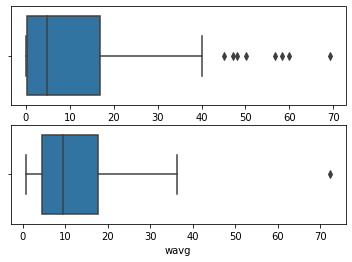

In [13]:
user_wavg_action_per_session = user_wavg_action_per_session.join(churn, user_wavg_action_per_session.userId == churn.userId)
a = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==0).toPandas()
b = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==1).toPandas()

f, axes = plt.subplots(2, 1)
ax1= sns.boxplot(x=a['wavg'], ax = axes[0])
ax2=sns.boxplot(x=b['wavg'], ax= axes[1])
plt.show()

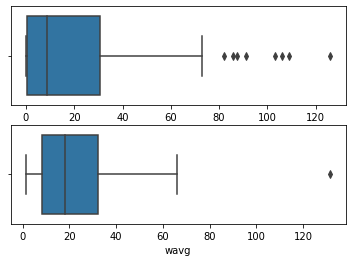

In [59]:
user_wavg_action_per_session = user_wavg_action_per_session.join(churn, user_wavg_action_per_session.userId == churn.userId)
a = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==0).toPandas()
b = user_wavg_action_per_session.filter(user_wavg_action_per_session['churn']==1).toPandas()

f, axes = plt.subplots(2, 1)
ax1= sns.boxplot(x=a['wavg'], ax = axes[0])
ax2=sns.boxplot(x=b['wavg'], ax= axes[1])
plt.show()

In [ ]:
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df.withColumn("userAgent", func_agent_device(df["userAgent"]))\
            .select(["userId", 'userAgent'])\
            .groupBy(["userId", 'userAgent'])\
            .agg(count("userAgent").alias("user_agent_usage"))\
            .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
            .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
            .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)\


In [ ]:
# Find the user's geographical division based on the first listed location state
path = "/content/drive/MyDrive/Đại học/Data/Churn/Sparkify/region.csv"
region = spark.read.csv(path, header=True)
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())
locations = df.withColumn('location', func_locations(df['location']))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])
locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")])\
    .withColumn('location', func_location_names('location'))
locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0)

In [ ]:
user_inf = churn.join(user_gender,['userId'])\
                .join(user_level,['userId'])\
                .join(user_sum_song,['userId'])\
                .join(user_thumb_up,['userId'])\
                .join(user_thumb_down,['userId'])\
                .join(user_ads,['userId'])\
                .join(user_last_reaction,['userId'])\
                .join(user_wavg_action_per_session,['userId'])\
                .withColumnRenamed('wavg','wavg_action')\
                .join(agents,['userId'])\
                .join(locations,['userId'])\

In [ ]:
a = user_inf.toPandas()

In [ ]:
a.head()

,userId,churn,gender,level,sum_song_listened,Thumb_up_times,Thumb_down_times,Num_ads,last_interaction,days_from_last_interaction,wavg_action,userId,churn,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,user_agent_iPad,user_agent_iPhone,location_east_north_central,location_east_south_central,location_middle_atlantic,location_mountain,location_new_england,location_pacific,location_south_atlantic,location_west_north_central,location_west_south_central
0,124,0,0,1,3339,171,41,4,1543590766000,2.415625,37.744709,124,0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0
1,7,0,1,0,148,7,1,16,1542955611000,9.766956,0.670127,7,0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
2,54,1,0,1,2414,163,29,47,1542051608000,20.229954,0.882775,54,1,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
3,15,0,1,1,1707,81,14,1,1543121818000,7.843264,10.629583,15,0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0
4,155,0,0,1,759,58,3,8,1543405710000,4.557477,39.067429,155,0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0


In [ ]:
import pandas as pd
a = pd.read_csv('/content/drive/MyDrive/Đại học/Data/Churn/Sparkify/test_part_1_small_sparkify.csv')

In [ ]:
a.head()

,userId,churn,gender,level,sum_song_listened,Thumb_up_times,Thumb_down_times,Num_ads,last_interaction,days_from_last_interaction,wavg_action,user_agent_Macintosh,user_agent_Windows,user_agent_X11,user_agent_compatible,user_agent_iPad,user_agent_iPhone,location_east_north_central,location_east_south_central,location_middle_atlantic,location_mountain,location_new_england,location_pacific,location_south_atlantic,location_west_north_central,location_west_south_central
0,124,0,0,1,3339,171,41,4,1543590766000,2.415625,36.577510,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0
1,7,0,1,0,148,7,1,16,1542955611000,9.766956,0.134025,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
2,54,1,0,1,2414,163,29,47,1542051608000,20.229954,0.176555,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0
3,15,0,1,1,1707,81,14,1,1543121818000,7.843264,2.125917,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0
4,155,0,0,1,759,58,3,8,1543405710000,4.557477,45.070630,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0


In [ ]:
user_inf.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- sum_song_listened: integer (nullable = false)
 |-- Thumb_up_times: integer (nullable = false)
 |-- Thumb_down_times: integer (nullable = false)
 |-- Num_ads: integer (nullable = false)
 |-- last_interaction: long (nullable = true)
 |-- days_from_last_interaction: float (nullable = true)
 |-- wavg_action: float (nullable = true)
 |-- user_agent_Macintosh: double (nullable = false)
 |-- user_agent_Windows: double (nullable = false)
 |-- user_agent_X11: double (nullable = false)
 |-- user_agent_compatible: double (nullable = false)
 |-- user_agent_iPad: double (nullable = false)
 |-- user_agent_iPhone: double (nullable = false)
 |-- location_east_north_central: long (nullable = true)
 |-- location_east_south_central: long (nullable = true)
 |-- location_middle_atlantic: long (nullable = true)
 |-- location_mountain: long (nullabl

In [ ]:
# joinDF.filter(joinDF['number_action_per_session']==0).count()
inrange_check_time.show()

NameError: ignored

In [ ]:
joinDF.show()

PythonException: ignored

In [ ]:
user_ads.show()

+------+-------+
|userId|Num_ads|
+------+-------+
|   125|      1|
|     7|     16|
|   124|      4|
|    54|     47|
|    15|      1|
|   155|      8|
|   154|     10|
|   132|      2|
|   101|      8|
|    11|     39|
|   138|     17|
|    29|     22|
|    69|      3|
|    42|     10|
|   112|     21|
|    87|     50|
|    73|      1|
|    64|      1|
|     3|      1|
|    30|     72|
+------+-------+
only showing top 20 rows



In [ ]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [ ]:
df.filter((df['userId']=='137')&(df['sessionId']==136)).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+-----------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|    event_date_time|registration_date_time|event_day_of_week|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------------------+-----------------+
|           Radiohead|Logged In|    Chase|     M|            0|    Ross| 264.6722| free|New York-Newark-J...|   PUT|NextSong|1532450666000|      136|Exit Mus

In [ ]:
print(f"Total number of rows in the dataset: {df.count()}.\n")
missing_count_total = 0

for coln in df.columns:
    missing_count = df.filter((isnan(df[coln])) | (df[coln].isNull()) | (df[coln] == "")).count()
    
    nan_count = df.filter(isnan(df[coln])).count()
    null_count = df.filter(df[coln].isNull()).count()
    empty_str = df.filter(df[coln] == "").count()
    print(f"{coln}: {missing_count} missing values. \
    {nan_count} NaN's; {null_count} Null's; {empty_str} empty strings.")
    missing_count_total += missing_count
        
if missing_count_total == 0:
    print("No missing values.")

Total number of rows in the dataset: 286500.

artist: 58392 missing values.     0 NaN's; 58392 Null's; 0 empty strings.
auth: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
firstName: 8346 missing values.     0 NaN's; 8346 Null's; 0 empty strings.
gender: 8346 missing values.     0 NaN's; 8346 Null's; 0 empty strings.
itemInSession: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
lastName: 8346 missing values.     0 NaN's; 8346 Null's; 0 empty strings.
length: 58392 missing values.     0 NaN's; 58392 Null's; 0 empty strings.
level: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
location: 8346 missing values.     0 NaN's; 8346 Null's; 0 empty strings.
method: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
page: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
registration: 8346 missing values.     0 NaN's; 8346 Null's; 0 empty strings.
sessionId: 0 missing values.     0 NaN's; 0 Null's; 0 empty strings.
song: 58392 missing values.     

Drop Na `userId`, `sectionId`


In [ ]:
df_d = df.dropna(how = 'any', subset=['userId', 'sessionId'])
df_d = df_d.filter(df_d['userId'] != '')
df_d.count()

# Check the number of missing values in userId and sessionId
# print("Number of missing values:")
# for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
#     missing_count = df_d.filter((isnan(df_d[coln])) | (df_d[coln].isNull()) | (df_d[coln] == "")).count()
#     print(f"    {coln}: {missing_count} missing values.")

278154

In [ ]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
churn = df_d.withColumn("churned", flag_churn_event("page"))\
    .select(['userId', 'churned'])\
    .groupBy('userId').agg(max('churned').alias("churn"))

func_levels = udf(lambda x: 1 if x=="paid" else 0, IntegerType())

#Check paid level
levels = df.select(['userId', 'level', 'ts'])\
    .orderBy(desc('ts'))\
    .dropDuplicates(['userId'])\
    .select(['userId', 'level'])\
    .withColumn('level', func_levels('level').cast(IntegerType()))

df_d.createOrReplaceTempView("df_table")

# Sum all time using app of a user
time_gender = spark.sql(
    '''
    SELECT userId, (MAX(ts) - AVG(registration)) / 1000 time_since_regi,
    AVG(CASE WHEN gender = "M" THEN 1 ELSE 0 END) gender
    FROM df_table
    GROUP BY userId
    '''
)

# Statistics of the time spent sper session (float)
per_session = spark.sql(
    '''
    SELECT userId, stddev_samp(time) std_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM df_table
        GROUP BY userId, sessionId) per_session
    GROUP BY userId
    '''
).fillna(0)

In [ ]:
# Calculate usage fraction of each userAgent
window = Window.partitionBy("userId").rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
func_agent_device = udf(lambda x: "user_agent_"+x.split('(')[1].replace(";", " ").split(" ")[0])

agents = df_d.withColumn("userAgent", func_agent_device(df_d["userAgent"]))\
    .select(["userId", 'userAgent'])\
    .groupBy(["userId", 'userAgent'])\
    .agg(count("userAgent").alias("user_agent_usage"))\
    .withColumn('total', Fsum(col('user_agent_usage')).over(window))\
    .withColumn('user_agent_usage', col('user_agent_usage')/col('total'))\
    .groupBy("userId").pivot("userAgent").sum("user_agent_usage").fillna(0)

# Count usages of each page event by each user
pages_to_exclude = ['Cancel', 'Downgrade', 'Cancellation Confirmation', 'Upgrade']
func_pages = udf(lambda x: "page_"+x.replace(" ", "_").lower())
pages = df_d.filter(~df_d['page'].isin(pages_to_exclude))\
    .withColumn("page", func_pages(df_d["page"]))\
    .groupBy(['userId']).pivot("page").agg(count('page'))\
    .fillna(0)
pages = pages.withColumn("page_up_down_ratio", pages["page_thumbs_up"]/(pages['page_thumbs_down']+0.1))

# Calculate the fraction of each page event by each user
pages = pages.withColumn(
    'total', sum(pages[coln] for coln in pages.columns if coln not in ['userId', 'page_up_down_ratio'])
)
for coln in pages.columns:
    if coln not in ['userId', 'total', 'page_up_down_ratio']:
        new_col_name = coln[0:5]+'frac_'+coln[5:]
        pages = pages.withColumn(new_col_name, pages[coln] / pages['total'])
pages = pages.drop('total')

# Find the user's geographical division based on the first listed location state
path = "/content/drive/MyDrive/Đại học/Data/Churn/Sparkify/region.csv"
region = spark.read.csv(path, header=True)
func_locations = udf(lambda x: x.split(', ')[1].split('-')[0])
func_location_names = udf(lambda x: "location_"+x.replace(" ", "_").lower())
locations = df_d.withColumn('location', func_locations(df_d['location']))\
    .select(['userId', 'location']).dropDuplicates(subset=['userId'])
locations = locations.join(region, locations['location']==region['State Code'], how='left')\
    .select(['userId', col("Division").alias("location")])\
    .withColumn('location', func_location_names('location'))
locations = locations.groupBy('userId').pivot('location').agg(count('location')).fillna(0)

In [ ]:
# Join features together
dataset = churn.join(levels, ['userId'])\
    .join(time_gender, ['userId'])\
    .join(per_session, ['userId'])\
    .join(agents, ['userId'])\
    .join(pages, ['userId'])\
    .join(locations, ['userId'])

cols_to_keep = [
    'userId', 'churn', 'level', 'time_since_regi', 'gender', 'std_time_per_session', 
    'user_agent_Macintosh', 'user_agent_Windows', 'user_agent_X11', 
    'user_agent_compatible', 'user_agent_iPad', 'user_agent_iPhone', 'page_about', 
    'page_error', 'page_roll_advert', 'page_save_settings', 'page_submit_downgrade', 
    'page_submit_upgrade', 'page_thumbs_down', 'page_thumbs_up', 'page_frac_about', 
    'page_frac_add_friend', 'page_frac_add_to_playlist', 'page_frac_error', 
    'page_frac_help', 'page_frac_home', 'page_frac_logout', 'page_frac_nextsong', 
    'page_frac_roll_advert', 'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 'page_frac_thumbs_down', 
    'page_frac_thumbs_up', 'location_east_north_central', 'location_east_south_central', 
    'location_middle_atlantic', 'location_mountain', 'location_new_england', 
    'location_pacific', 'location_south_atlantic', 'location_west_north_central', 
    'location_west_south_central', 'page_up_down_ratio'
]
dataset = dataset.select(cols_to_keep)

# Feature transformation
to_sqrt = ['std_time_per_session']
to_log = [
    'page_about', 'page_error', 'page_roll_advert', 'page_save_settings', 
    'page_thumbs_down', 'page_frac_about', 'page_frac_add_friend', 
    'page_frac_add_to_playlist', 'page_frac_error', 'page_frac_help', 
    'page_frac_home', 'page_frac_logout', 'page_frac_roll_advert', 
    'page_frac_save_settings', 'page_frac_settings', 
    'page_frac_submit_downgrade', 'page_frac_submit_upgrade', 
    'page_frac_thumbs_down', 'page_settings', 'page_thumbs_up',
    'page_up_down_ratio'
]

col_names = [
    coln for coln in dataset.columns if 
    ('churn' not in coln) and 
    ('level' not in coln) and
    ('userId' not in coln) and
    ('gender' not in coln) and
    ('user_agent_' not in coln) and
    ('location_' not in coln) and
    ('_submit_' not in coln)
]
for col_name in col_names:
    if col_name in to_sqrt:
        dataset = dataset.withColumn(col_name, sqrt(dataset[col_name]+1))
    elif col_name in to_log:
        dataset = dataset.withColumn(col_name, log(dataset[col_name]+1))



In [ ]:
# Rename churn column into label
dataset = dataset.withColumn('label', dataset['churn'].cast('float')).drop('churn') #important to have float type

# Feature columns to be converted into vector

In [ ]:
# Train-test split
train, test = dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)

In [ ]:
def buildCV(classifier, paramGrid, feature_cols):
    '''
    Build a cross validation pipeline
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    crossval: cross validator
    '''
    # Configure an ML pipeline
    assembler = VectorAssembler(inputCols=feature_cols,outputCol="rawFeatures")
    assembler.setInputCols
    scaler = MaxAbsScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
#     scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures", withStd=True, withMean=True)
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3
    )
    return crossval

def trainModel(classifier, train, paramGrid, feature_cols):
    '''
    Train the machine learning model
    
    INPUT
    classifier: untrained machine learning classifier
    paramGrid: a grid of parameters to search over
    train (Spark dataframe): training dataset
    
    OUTPUT
    model: trained machine learning model
    training_time (float): training time
    '''
    crossval = buildCV(classifier, paramGrid, feature_cols)
    start = time()
    model = crossval.fit(train)
    end = time()
    training_time = end - start
    return model, training_time

def evaluateModel(model, data, prob=False):
    '''
    Evaluate model performance
    
    INPUT
    model: trained machine learning model
    data (Spark dataframe): either training set or testing set
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics
    '''
    # Make prediction
    start = time()
    pred = model.transform(data)
    if prob:
        evaluator = MulticlassClassificationEvaluator(predictionCol="probability", labelCol="label")
    else:
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    end = time()
    prediction_time = end - start
    
    # Calculate metrics
    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
    evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()
    evalMetrics['prediction_time'] = prediction_time
    
    return evalMetrics

def evaluateTrainTest(model, train, test, training_time):
    '''
    Evaluate model performance on both training and testing sets
    
    INPUT
    model: trained machine learning model
    train: training set
    test: testing set
    training_time (float): training time
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    '''
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary
# Lump all steps together

In [ ]:
def trainAndEval(classifier, train, test, paramGrid):
    '''
    Train and evaluate model performance on both training and testing sets
    
    INPUT
    classifier: untrained machine learning classifier
    train: training set
    test: testing set
    paramGrid: a grid of parameters to search over
    
    OUTPUT
    evalMetrics (dict): disctionary of evaluation metrics, 
        compiled from training, testing metrics
    summary (Spark dataframe): table of evaluation metrics
    model: trained machine learning model
    '''
    # Train the model
    model, training_time = trainModel(classifier, train, paramGrid)
    
    # Evaluate model performance
    evalMetricsTraining = evaluateModel(model, train)
    evalMetricsTesting = evaluateModel(model, test)

    # Compile metrics
    evalMetrics = {}
    evalMetrics['train_time'] = training_time
    evalMetrics['f1_train'] = evalMetricsTraining['f1']
    evalMetrics['acc_train'] = evalMetricsTraining['accuracy']
    evalMetrics['f1_test'] = evalMetricsTesting['f1']
    evalMetrics['acc_test'] = evalMetricsTesting['accuracy']
    evalMetrics['pred_time'] = evalMetricsTraining['prediction_time'] \
        + evalMetricsTesting['prediction_time']

    # Summarize metrics into a Spark dataframe
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))
    
    return evalMetrics, summary, model

In [ ]:
train.count()

190

In [ ]:
# Train the model and evaluate performance
classifier = GBTClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
# evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)
feature_col = dataset.drop('label').drop('userId').columns
model, training_time = trainModel(classifier, train, paramGrid, feature_col)
# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.save("gradient_boosted_tree")
# bestCLModel.write().overwrite().save("gradient_boosted_tree")

# Show metrics
print("Gradient-Boosted Tree:")
summary.show()

Gradient-Boosted Tree:


NameError: ignored

In [ ]:
# Train the model and evaluate performance
classifier = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")
paramGrid=ParamGridBuilder().build()
evalMetrics, summary, model = trainAndEval(classifier, train, test, paramGrid)

# Save the best model
bestModel = model.bestModel
bestCLModel = bestModel.stages[2]
bestCLModel.save("random_forest")
# bestCLModel.write().overwrite().save("random_forest")

# Show metrics
print("Random Forest:")
summary.show()

Random Forest:
+----------+--------+---------+-------+--------+---------+
|train_time|f1_train|acc_train|f1_test|acc_test|pred_time|
+----------+--------+---------+-------+--------+---------+
|  631.4465|  0.9144|   0.9211| 0.7584|     0.8|   1.4689|
+----------+--------+---------+-------+--------+---------+

